<a href="https://colab.research.google.com/github/ShuqairABD/Autodistill---face-detection---video-test/blob/main/Autodistill_face_detection_video_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Feb  8 16:35:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##  Install autodistill



In [ ]:
# Установка библиотеки
!pip install -q autodistill==0.1.24
!pip install -q autodistill-grounded-sam
!pip install -q autodistill_yolov8
!pip install -q roboflow
!pip install -q supervision==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.3 M

In [ ]:
# Импорт модуля os для работы с операционной системой
import os

# Получение текущего рабочего каталога и сохранение в переменной HOME
HOME = os.getcwd()

# Вывод текущего рабочего каталога
print(HOME)

/content


In [ ]:
# Создание нового каталога "images" в HOME каталоге
!mkdir {HOME}/images

### Download raw videos



In [ ]:
# Создание каталога "videos" в домашнем каталоге
!mkdir -p {HOME}/videos

# Смена текущего рабочего каталога на каталог "videos"
%cd {HOME}/videos

/content/videos


In [ ]:
# Импорт необходимой библиотеки для загрузки файлов
from google.colab import files

# Загрузка zip-файла с видео
uploaded = files.upload()

Saving Video.zip to Video.zip


In [ ]:
# Переход в каталог, где находится zip-файл
%cd /content/videos

# Разархивирование файла
!unzip Video.zip

/content/videos
Archive:  Video.zip
  inflating: 1.mp4                   
  inflating: 2.mp4                   
  inflating: 3.mp4                   
  inflating: 4.mp4                   
  inflating: 5.mp4                   
  inflating: 6.mp4                   
  inflating: 7.mp4                   
  inflating: 8.mp4                   


### Convert videos into images



In [ ]:
#Путь к каталогу с видео
VIDEO_DIR_PATH = f"{HOME}/videos"

# Путь к каталогу для изображений
IMAGE_DIR_PATH = f"{HOME}/images"

# Шаг между кадрами для извлечения из видео
FRAME_STRIDE = 10

In [ ]:
# Импорт библиотеки для обработки видео
import supervision as sv

# Импорт библиотеки для отображения прогресса
from tqdm.notebook import tqdm

# Получение путей к видео
video_paths = VIDEO_DIR_PATH = f"{HOME}/videos"
video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

# Разделение видео на тестовое и тренировочное подмножества
TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

# Итерация по тренировочным видео
for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"

    # Создание объекта для сохранения изображений
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/3 [00:00<?, ?it/s]

### Display image sample



In [ ]:
# Импорт библиотеки для обработки изображений
import supervision as sv

# Получение путей к изображениям
image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

# Вывод количества изображений
print('image count:', len(image_paths))

image count: 432


In [ ]:
# Путь к каталогу с изображениями
IMAGE_DIR_PATH = f"{HOME}/images"

# Размер выборки изображений
SAMPLE_SIZE = 16

# Размер сетки выборки изображений
SAMPLE_GRID_SIZE = (4, 4)

# Размер графика выборки изображений
SAMPLE_PLOT_SIZE = (16, 16)

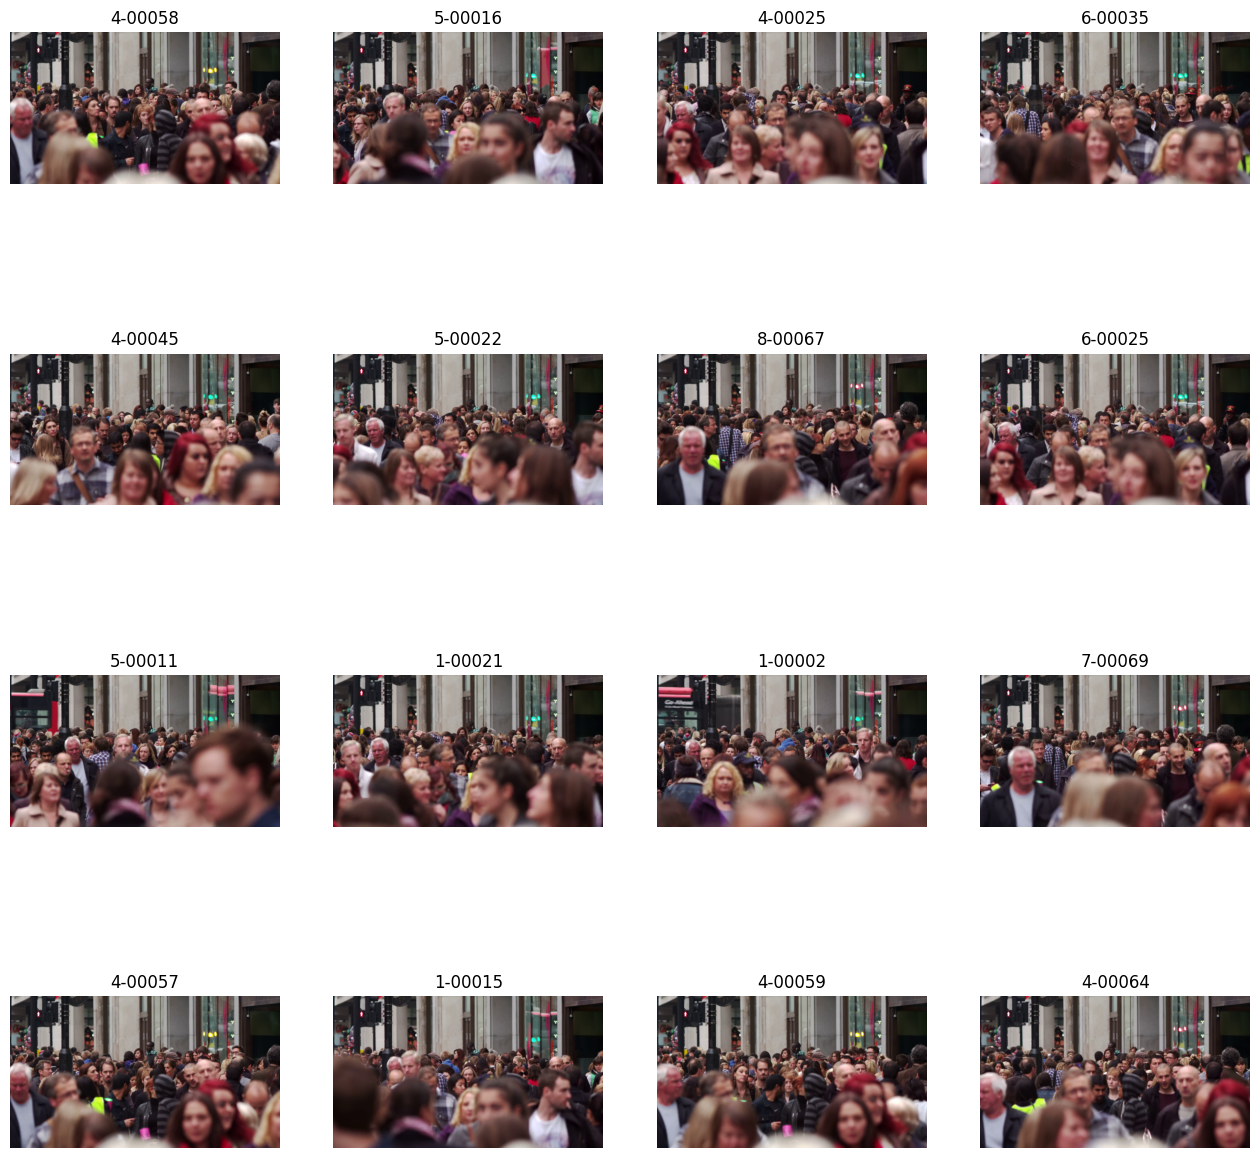

In [ ]:
import cv2
import supervision as sv

# Заголовки изображений
titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

# Построение сетки изображений
sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## Autolabel dataset / ontology

In [ ]:
# Импорт класса CaptionOntology из модуля autodistill.detection
from autodistill.detection import CaptionOntology

# Создание экземпляра класса CaptionOntology с указанием соответствий между категориями
ontology=CaptionOntology({
    "human body": "body",
    "human head": "head"
})

### Autodistill


In [ ]:
# Путь к каталогу с датасетом
DATASET_DIR_PATH = f"{HOME}/dataset"

In [ ]:
from autodistill_grounded_sam import GroundedSAM

# Создание базовой модели GroundedSAM с использованием определенной онтологии
base_model = GroundedSAM(ontology=ontology)

# Маркировка датасета с изображениями
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Labeling /content/images/4-00058.png:   0%|          | 0/432 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two 

Labeled dataset created - ready for distillation.


### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [ ]:
# Путь к каталогу с аннотациями
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"

# Путь к каталогу с изображениями
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"

# Путь к файлу YAML с данными
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [ ]:
# Импорт библиотеки для обработки данных
import supervision as sv

# Создание датасета DetectionDataset из формата YOLO
dataset = sv.DDetectionataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

345

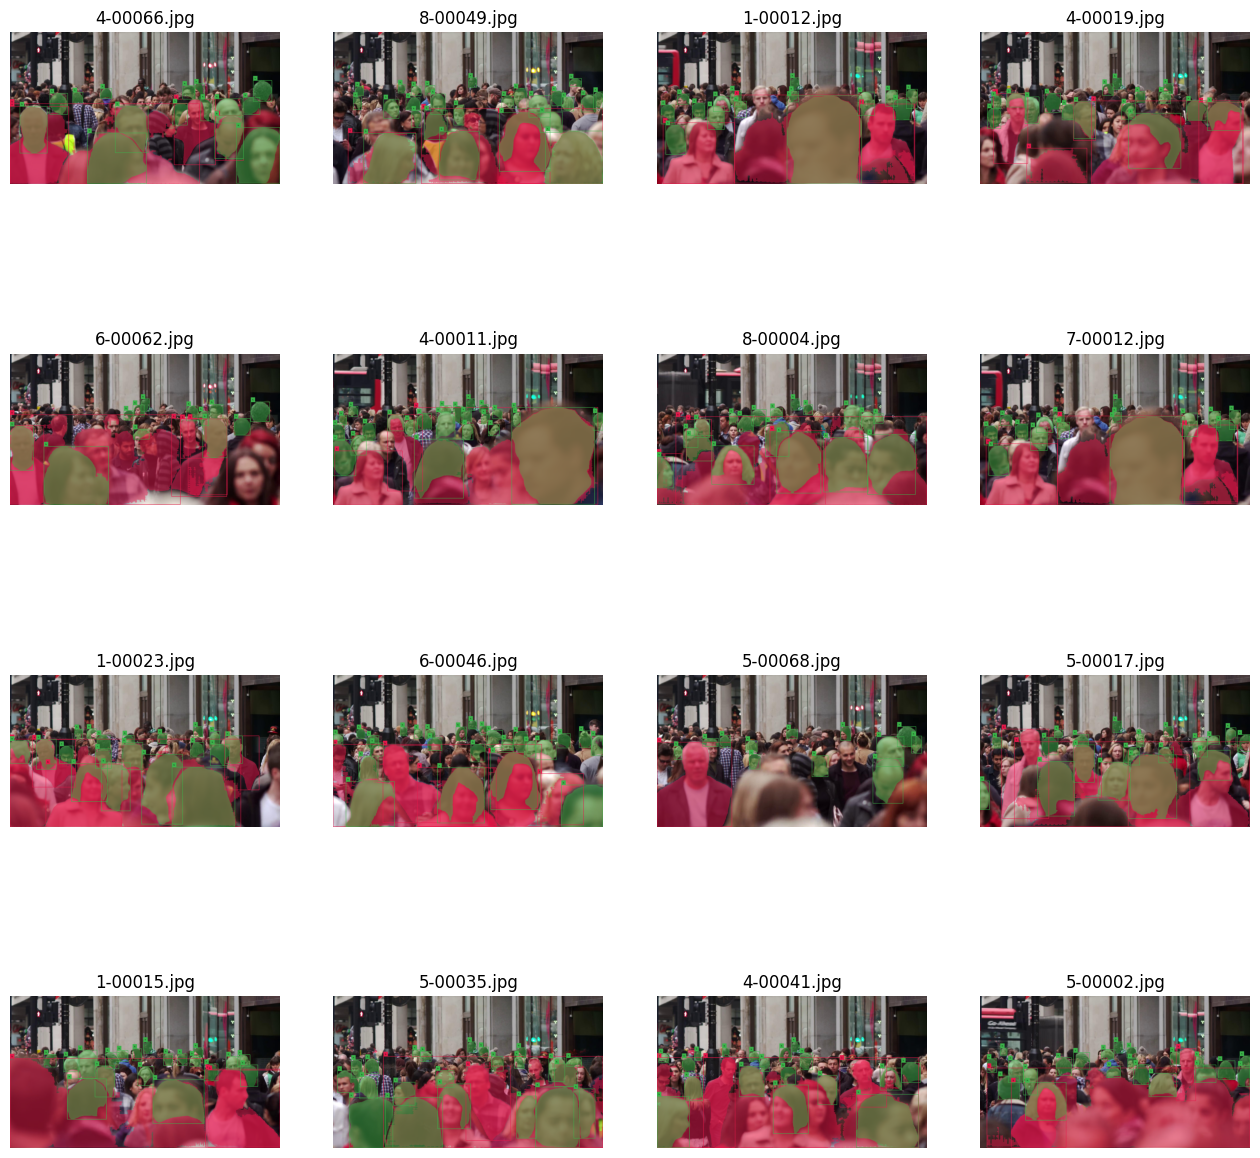

In [ ]:
import supervision as sv

# Получение имен изображений из датасета
image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

# Создание объектов для аннотации масок и прямоугольников
mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
# Итерация по именам изображений
for image_name in image_names:

    # Получение изображения и аннотаций
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]

    # Получение меток для аннотаций
    labels = [dataset.classes[class_id][0] for class_id in annotations.class_id]  # Modify here

    # Аннотация изображения масками
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)

    # Аннотация изображения прямоугольниками
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

# Построение сетки изображений с аннотациями
sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)


##  Train target model - YOLOv8


In [ ]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

# Создание целевой модели YOLOv8
target_model = YOLOv8("yolov8n.pt")

# Обучение целевой модели на датасете
target_model.train(DATA_YAML_PATH, epochs=30)


/content


100%|██████████| 6.23M/6.23M [00:00<00:00, 334MB/s]
New https://pypi.org/project/ultralytics/8.1.10 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=F

## Evaluate target model



/content


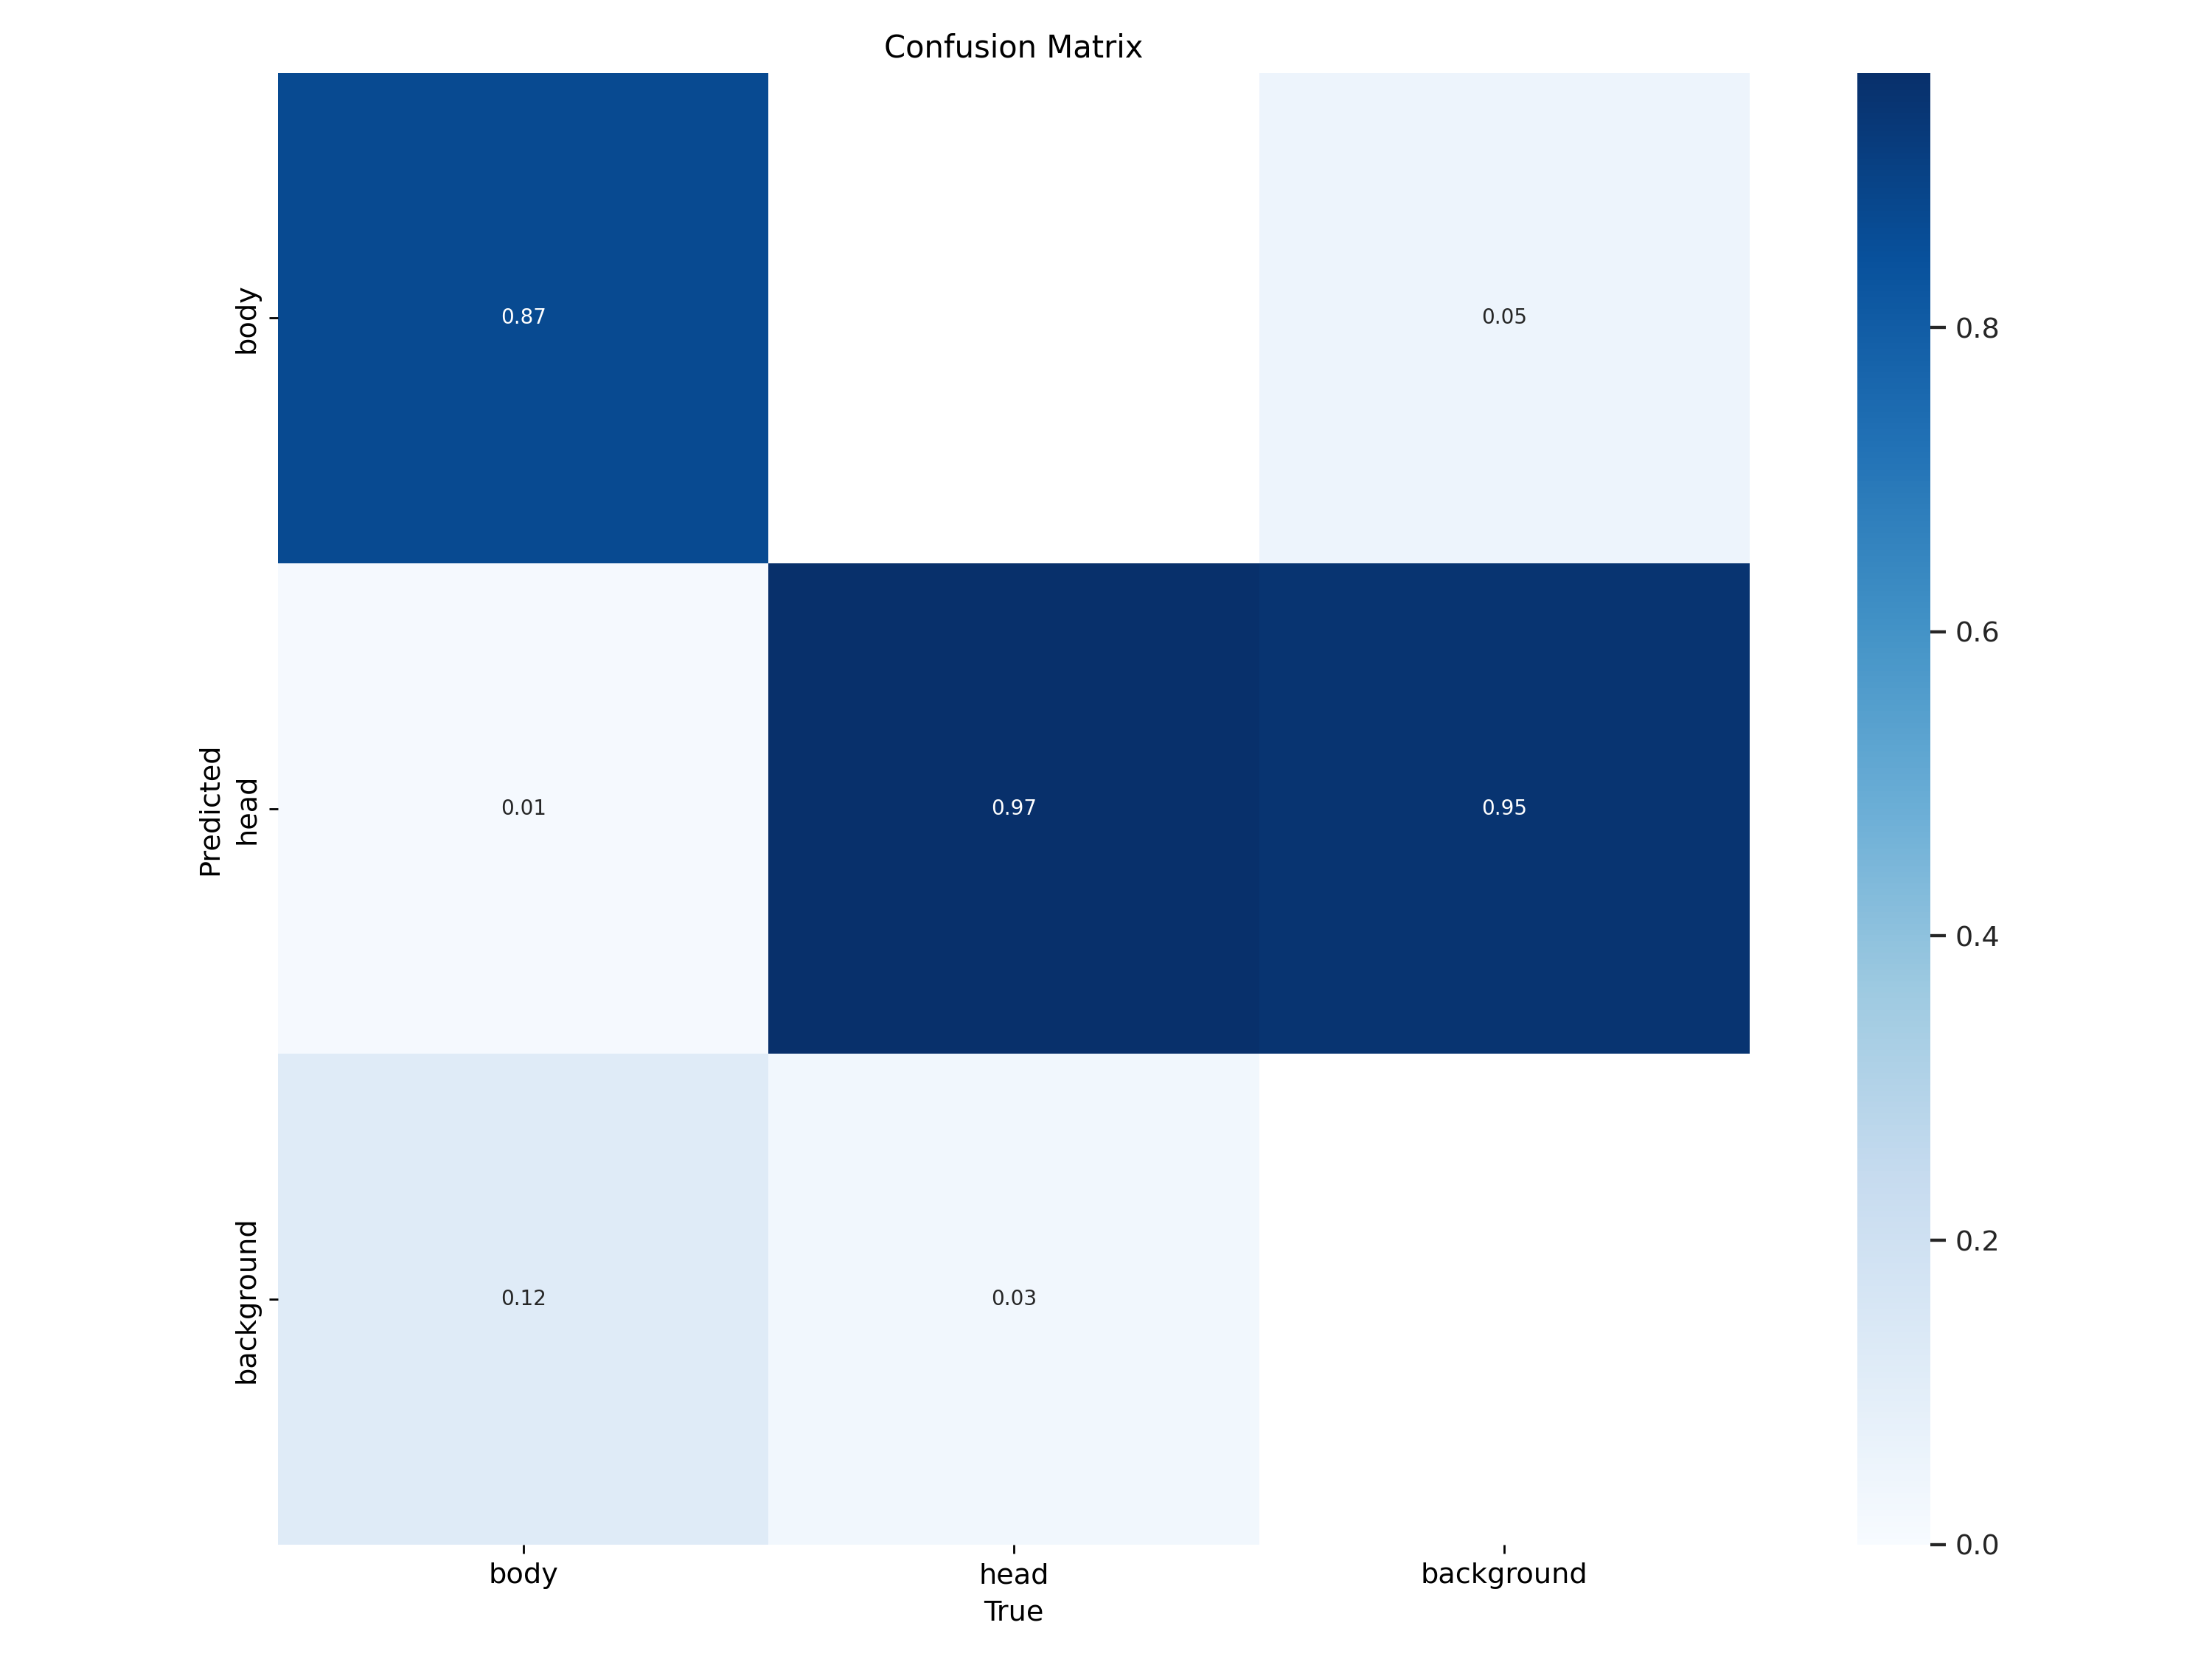

In [ ]:
%cd {HOME}

# Импорт функции Image из модуля IPython.display
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


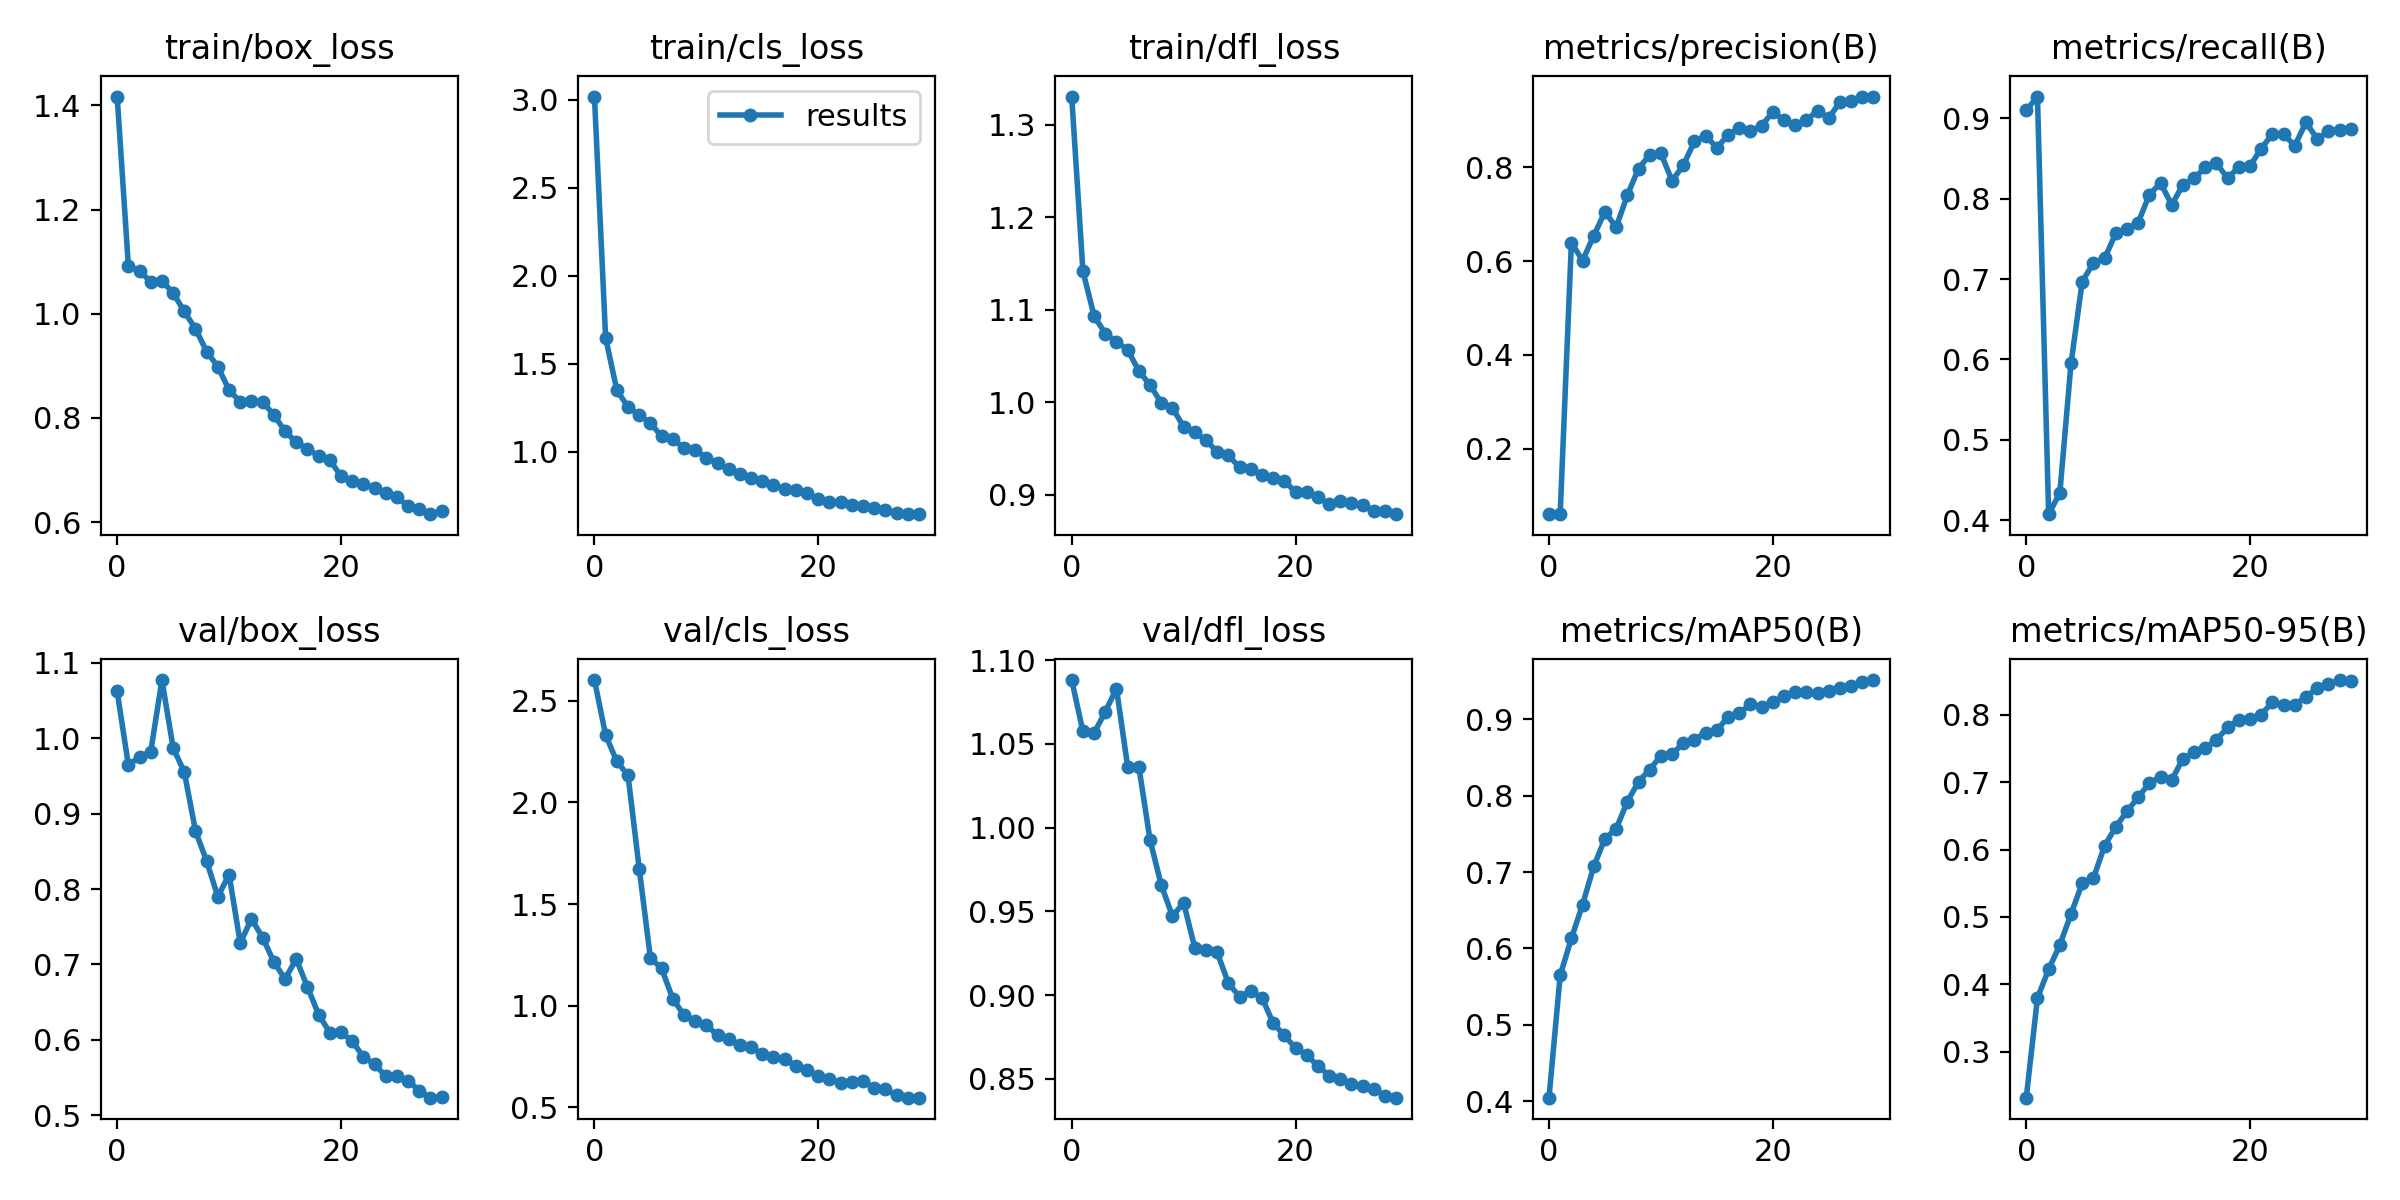

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=900)

/content


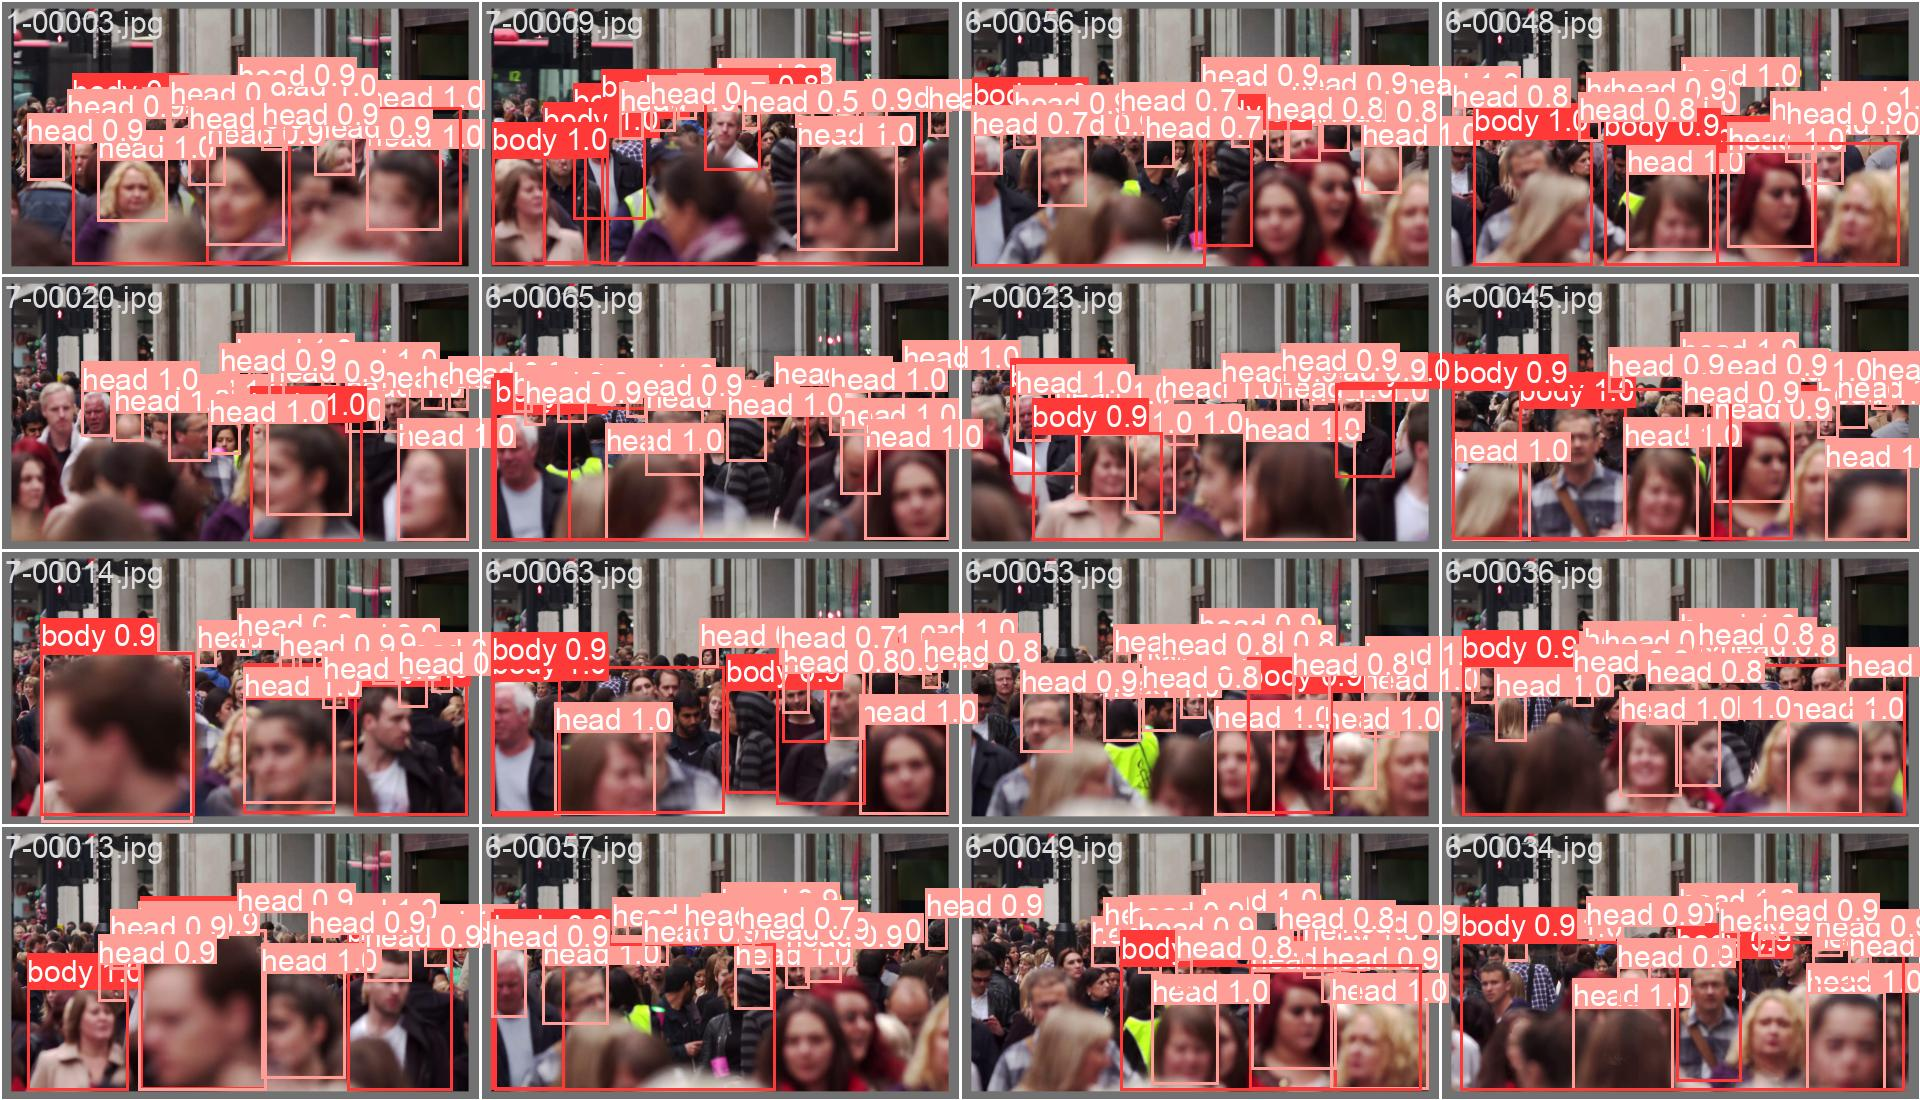

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=900)

/content


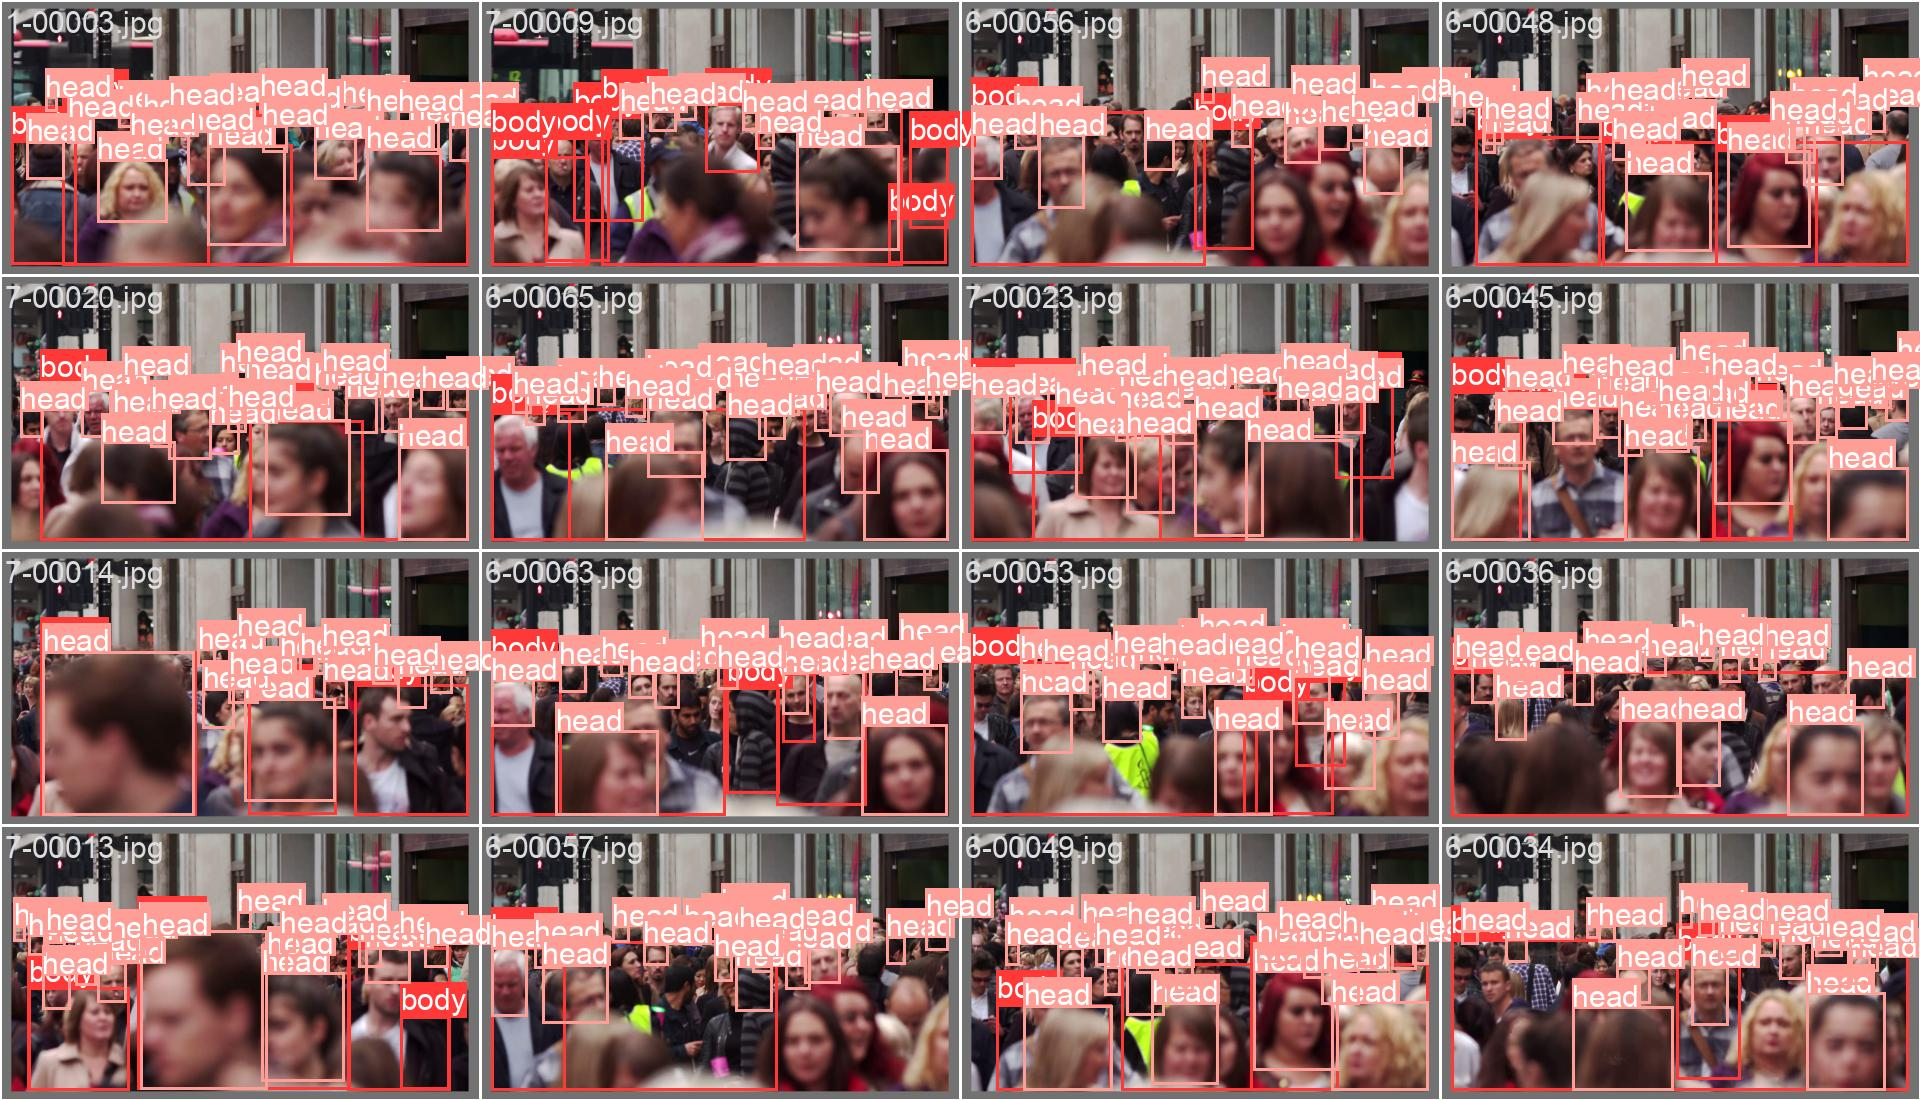

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_labels.jpg', width=1200)

##  Run Inference on a video

In [ ]:
# Импорт модуля locale для работы с локальными настройками
import locale

# Установка предпочтительной кодировки на UTF-8
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [ ]:
#!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

In [ ]:
# Запуск команды для выполнения предсказания с использованием модели YOLO.
#   - model: путь к файлу весов модели
#   - source: путь к исходному видеофайлу для предсказания

!yolo predict model={HOME}/runs/detect/train/weights/best.pt source={HOME}/videos/1.mp4


2024-02-08 19:38:00.644443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 19:38:00.644501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 19:38:00.645775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

video 1/1 (1/711) /content/videos/1.mp4: 384x640 1 body, 25 heads, 82.0ms
video 1/1 (2/711) /content/videos/1.mp4: 384x640 1 body, 25 heads, 45.0ms
video 1/1 (3/711) /content/videos/1.mp4: 384x640 1 body, 26 heads, 42.7ms


In [ ]:
# Импорт функции Video из модуля IPython.display
from IPython.display import Video

# Путь к видеофайлу
video_path = '/content/runs/detect/predict5/1.mp4'

# Отображение видео
Video(video_path)


In [ ]:
from IPython.display import HTML

# Путь к выходному видеофайлу после обработки
output_video_path = '/content/runs/detect/predict5/1.mp4'

# Генерация HTML-кода для отображения видео
html_code = f"""
<video width="640" height="480" controls>
  <source src="{output_video_path}" type="video/mp4">
  Your browser does not support the video tag.
</video>
"""

# Отображение HTML-кода
HTML(html_code)


In [ ]:
# Импорт функции Download из модуля google.colab
from google.colab import files

# Путь к файлу для загрузки
file_path = '/content/runs/detect/predict5/1.mp4'

# Загрузка файла
files.download(file_path)